# Running an MSTIS simulation

Now we will use the initial trajectories we obtained from bootstrapping to run an MSTIS simulation. This will show both how objects can be regenerated from storage and how regenerated equivalent objects can be used in place of objects that weren't stored.

Tasks covered in this notebook:
* Loading OPS objects from storage
* Ways of assigning initial trajectories to initial samples
* Setting up a path sampling simulation with various move schemes
* Visualizing trajectories while the path sampling is running

In [1]:
%matplotlib inline
import openpathsampling as paths
import numpy as np
import math

In [2]:
# Imports for plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.legend_handler import HandlerLine2D

### Loading things from storage

First we'll reload some of the stuff we stored before. Of course, this starts with opening the file.

In [3]:
old_store = paths.AnalysisStorage("ala.nc")

A lot of information can be recovered from the old storage, and so we don't have the recreate it. However, we did not save our network, so we'll have to create a new one. Since the network creates the ensembles, that means we will have to translate the trajectories from the old ensembles to new ensembles.

In [4]:
print "PathMovers:", len(old_store.pathmovers)
print "Engines:", len(old_store.engines)
print "Samples:", len(old_store.samples)
print "Ensembles:", len(old_store.ensembles)
print "SampleSets:", len(old_store.samplesets)
print "Snapshots:", len(old_store.snapshots)
print "Networks:", len(old_store.networks)

PathMovers: 0
Engines: 2
Samples: 28
Ensembles: 351
SampleSets: 1
Snapshots: 2516
Networks: 1


Loading from storage is very easy. Each store is a list. We take the 0th snapshot as a template (it doesn't actually matter which one) for the next storage we'll create. There's only one engine stored, so we take the only one.

In [5]:
template = old_store.snapshots[0]

In [6]:
engine = old_store.engines.find_first('default')

In [7]:
mstis = old_store.networks[0]

Now we need to set up real trajectories that we can use for each of these. We can start by loading the stored sample set.

In [8]:
sset = paths.SampleSet(old_store.samplesets[0])

In [9]:
sset.sanity_check()
assert(len(sset)==28)

### Setting up special ensembles

Whichever way we initially set up the `SampleSet`, at this point it only contains samples for the main sampling trajectories of each transition. Now we need to put trajectories into various auxiliary ensembles.

#### Multiple state outer ensemble

The multiple state outer ensemble is, in fact, sampled during the bootstrapping. However, it is actually sampled once for every state that shares it. It is very easy to find a trajectory that satisfies the ensemble and to load add that sample to our sample set.

In [10]:
for outer_ens in mstis.special_ensembles['ms_outer']:
    # doesn't matter which we take, so we take the first
    traj = next(s.trajectory for s in old_store.samplesets[0] if outer_ens(s.trajectory)==True)
    samp = paths.Sample(
            replica=None,
            ensemble=outer_ens,
            trajectory=traj
    )
    # now we apply it and correct for the replica ID
    sset.append_as_new_replica(samp)

In [11]:
sset.sanity_check()
assert(len(sset)==29)

#### Minus interface ensemble

The minus interface ensembles do not yet have a trajectory. We will generate them by starting with same-state trajectories (A-to-A, B-to-B, C-to-C) in each interface, and extending into the minus ensemble.

* check whether the traj is A-to-A
* extend

First we need to make sure that the trajectory in the innermost ensemble of each state also ends in that state. This is necessary so that when we extend the trajectory, it can extends into the minus ensemble.

If the trajectory isn't right, we run a shooting move on it until it is.

In [12]:
for transition in mstis.sampling_transitions:
    innermost_ensemble = transition.ensembles[0]
    shooter = None
    if not transition.stateA(sset[innermost_ensemble].trajectory[-1]):
        shooter = paths.OneWayShootingMover(ensemble=innermost_ensemble,
                                            selector=paths.UniformSelector())
        pseudoscheme = paths.LockedMoveScheme(root_mover=shooter)
        pseudosim = paths.PathSampling(storage=None, 
                                       move_scheme=pseudoscheme, 
                                       globalstate=sset,
                                       engine=engine
                                      )
    while not transition.stateA(sset[innermost_ensemble].trajectory[-1]):
        pseudosim.run(1)
        sset = pseudosim.globalstate

    

Working on Monte Carlo cycle number 12.

DONE! Completed 12 Monte Carlo cycles.



Now that all the innermost ensembles are safe to use for extending into a minus interface, we extend them into a minus interface:

In [13]:
def traj_info(traj, ensemble):
    return traj.summarize_by_volumes_str(
            {"A" : ensemble.state_vol,
             "I" : ~ensemble.state_vol & ensemble.innermost_vol,
             "X" : ~ensemble.innermost_vol})

In [14]:
minus_samples = []
for transition in mstis.sampling_transitions:
#    paths.tools.refresh_output('Creating minus sample for %s' % transition.name) 
    print transition.name,
    choices = list()
    from_state = transition.stateA
    max_length = 10
    while len(choices) == 0: 
        leaveSt = paths.SequentialEnsemble([
                paths.AllInXEnsemble(from_state),
                paths.SingleFrameEnsemble(
                    paths.AllOutXEnsemble(from_state)
                )
            ])
        extend = paths.LengthEnsemble(slice(0,max_length)) & paths.SequentialEnsemble([
                paths.AllOutXEnsemble(from_state),
                paths.SingleFrameEnsemble(
                    paths.AllInXEnsemble(from_state)
                )
            ])
        part1 = sset[transition.ensembles[0]].trajectory
        part2 = engine.generate_forward(part1[-1], leaveSt)
        part3 = engine.generate_forward(part2[-1], extend)
        
#        print len(part1), len(part2), len(part3)
        
        attempt = part1 + part2[1:] + part3[1:]
        
#         attempt = transition.minus_ensemble.populate_minus_ensemble(
#             partial_traj=sset[transition.ensembles[0]].trajectory,
#             minus_replica_id=-len(minus_samples)-1,
#             engine=engine
#         )
        choices = transition.minus_ensemble.split(attempt)
    
        print '%2d' % max_length,
        
        max_length += 5

    print '(%2d) %s' % (len(attempt), traj_info(attempt, transition.minus_ensemble))
        
    minus_samples.append(
        paths.Sample(
            replica=-len(minus_samples)-1,
            trajectory=choices[0],
            ensemble=transition.minus_ensemble
        )        
    )
    
sset = sset.apply_samples(minus_samples)

Out B0 10 15 20 25 (35) A-X-A-X-A
Out F0 10 (26) A-X-A-X-A
Out D0 10 15 20 25 30 35 40 45 50 (51) A-X-A-X-A
Out A0 10 (50) A-X-A-X-A
Out E0 10 15 (21) A-X-A-X-A
Out C0 10 (18) A-X-A-X-A


In [15]:
sset.sanity_check()
assert(len(sset)==35)

In [16]:
for s in sset:
    print s.replica, len(s.trajectory), s.ensemble.name, s.ensemble(s.trajectory)

1 31 I'face 1 True
2 39 I'face 2 True
3 39 I'face 3 True
4 39 [TISEnsemble] True
5 15 I'face 0 True
6 31 I'face 1 True
7 77 I'face 2 True
8 77 [TISEnsemble] True
9 12 I'face 0 True
10 12 I'face 1 True
11 79 I'face 2 True
12 53 I'face 3 True
13 53 [TISEnsemble] True
14 19 I'face 0 True
15 31 I'face 1 True
16 31 I'face 2 True
17 36 I'face 3 True
18 36 [TISEnsemble] True
19 13 I'face 0 True
20 13 I'face 1 True
21 12 I'face 2 True
22 12 [TISEnsemble] True
23 19 I'face 0 True
24 19 I'face 1 True
25 18 I'face 2 True
26 87 I'face 3 True
27 87 [TISEnsemble] True
28 37 [UnionEnsemble] True
0 48 I'face 0 True
-1 35 [MinusInterfaceEnsemble] True
-2 26 [MinusInterfaceEnsemble] True
-3 51 [MinusInterfaceEnsemble] True
-4 50 [MinusInterfaceEnsemble] True
-5 21 [MinusInterfaceEnsemble] True
-6 18 [MinusInterfaceEnsemble] True


## Equilibration

In molecular dynamics, you need to equilibrate if you don't start with an equilibrium frame (e.g., if you start with solvent molecules on a grid, your system should equilibrate before you start taking statistics). Similarly, if you start with a set of paths which are far from the path ensemble equilibrium, you need to equilibrate. This could either be because your trajectories are not from the real dynamics (generated with metadynamics, high temperature, etc.) or because your trajectories are not representative of the path ensemble (e.g., if you put transition trajectories into all interfaces).

As with MD, running equilibration can be the same process as running the total simulation. However, in path sampling, it doesn't have to be: we can equilibrate without replica exchange moves or path reversal moves, for example. In the example below, we create a `MoveScheme` that only includes shooting movers.

In [17]:
equil_scheme = paths.MoveScheme(mstis)
import openpathsampling.analysis.move_strategy as strat
equil_scheme.append([
        strat.OneWayShootingStrategy(), 
        strat.OrganizeByMoveGroupStrategy()
    ])

In [18]:
equilibration = paths.PathSampling(
    storage=None,
    globalstate=sset,
    engine=engine,
    move_scheme=equil_scheme
)

In [19]:
equilibration.run(20)

Working on Monte Carlo cycle number 20.

DONE! Completed 20 Monte Carlo cycles.



In [20]:
sset = equilibration.globalstate

## Running RETIS

Now we run the full calculation. Up to here, we haven't been storing any of our results. This time, we'll start a storage object, and we'll save the network we've created. Then we'll run a new `PathSampling` calculation object.

In [21]:
# logging creates ops_output.log file with details of what the calculation is doing
#import logging.config
#logging.config.fileConfig("logging.conf", disable_existing_loggers=False)

In [22]:
storage = paths.storage.Storage("weina_production.nc", "w", template)

In [23]:
mstis_calc = paths.PathSampling(
    storage=storage,
    globalstate=sset,
    engine=engine,
    move_scheme=paths.DefaultScheme(mstis)
)
mstis_calc.save_frequency = 10

The next block sets up a live visualization. This is optional, and only recommended if you're using OPS interactively (which would only be for very small systems). Some of the same tools can be used to play back the behavior after the fact if you want to see the behavior for more complicated systems. You can create a background (here we use the PES contours), and the visualization will plot the trajectories.

In [24]:
phi = old_store.cvs.find_first('phi')
psi = old_store.cvs.find_first('psi')

In [25]:
phiD = lambda x : phi(x) * 180/3.14159
psiD = lambda x : psi(x) * 180/3.14159

In [26]:
state_centers = {
    'A' : [-150, 150], 
    'B' : [-70, 135], 
    'C' : [-150, -65], 
    'D' : [-70, -50], 
    'E' : [50, -100], 
    'F' : [40, 65]
}
interface_levels = {
    'A' : [10, 20, 45, 65, 80],
    'B' : [10, 20, 45, 65, 75],
    'C' : [10, 20, 45, 60],
    'D' : [10, 20, 45, 60],
    'E' : [10, 20, 45, 65, 80],
    'F' : [10, 20, 45, 65, 80],
    'alpha' : [10, 20, 45, 55, 65, 75],
    'beta' : [10, 20, 40, 45, 50, 60],    
}

In [27]:
def cvlines(data, *cvs):
    all_points = [cv(data) for cv in cvs]
    ret = []
    first = 0
    for d in range(1,len(data)):
        flip = False
        for c in range(len(cvs)):
            if periodicflip(all_points[c][d], all_points[c][d-1], math.pi):
                flip = True
                                
        if flip:
            ret.append([all_points[c][first:d] for c in range(len(cvs))])
            first = d

    ret.append([all_points[c][first:d+1] for c in range(len(cvs))])    
            
    return ret
            
    
def periodicflip(val1, val2, period):
    return (period**2 - (val1 - val2)**2) < (val1 - val2)**2

In [28]:
%config InlineBackend.figure_format='retina'

def plot_main():
    plt.figure(figsize=(8, 8))
    rect = plt.Rectangle((-180,-180),360,360, facecolor="none", edgecolor="none")    
    
    plt.xlim(-180, 180);
    plt.ylim(-180, 180);    
    
    centers = state_centers.values()

    plt.plot([x[0] for x in centers], [x[1] for x in centers], 'ko')

    fig = plt.gcf()

    for level in range(100,0,-1):
        for col in [True, False]:
            for name, center in state_centers.iteritems():
                if level == 1:
                    plt.annotate(name, xy=center, xytext=(center[0]+10 + 1, center[1] - 1), fontsize=20, color='k')
                    plt.annotate(name, xy=center, xytext=(center[0]+10, center[1]), fontsize=20, color='w')

                if level in interface_levels[name]:
                    for xp in [-1, 0, 1]:
                        for yp in [-1, 0, 1]:
                            if col:
                                circle = plt.Circle((center[0] + xp * 360, center[1] + yp * 360), level, color='w')
                                fig.gca().add_artist(circle)
                            else:
                                l = 1.0 * level / 100
                                circle = plt.Circle(
                                    (center[0] + xp * 360, center[1] + yp * 360), 
                                    level - 1, 
                                    color=(l + 0.0,l + 0.2, 0.6)
                                )
                                fig.gca().add_artist(circle)

                        # circle.set_clip_path(rect)

    plt.axis('equal')
    plt.axis((-180,180,-180,180))
                    
    plt.xlim(-180, 180);
    plt.ylim(-180, 180);    
    
    return fig

In [29]:
def plot_traj(traj):    
    angles = cvlines(traj, phi, psi)
    degrees = 180/3.14159 # psi reports in radians; I think in degrees
    for angle in angles:
        plt.plot(degrees * np.array(angle[0])[:], degrees * np.array(angle[1])[:], 'ko', linewidth=0.5)
        plt.plot(degrees * np.array(angle[0])[:], degrees * np.array(angle[1])[:], 'k-', linewidth=0.5)

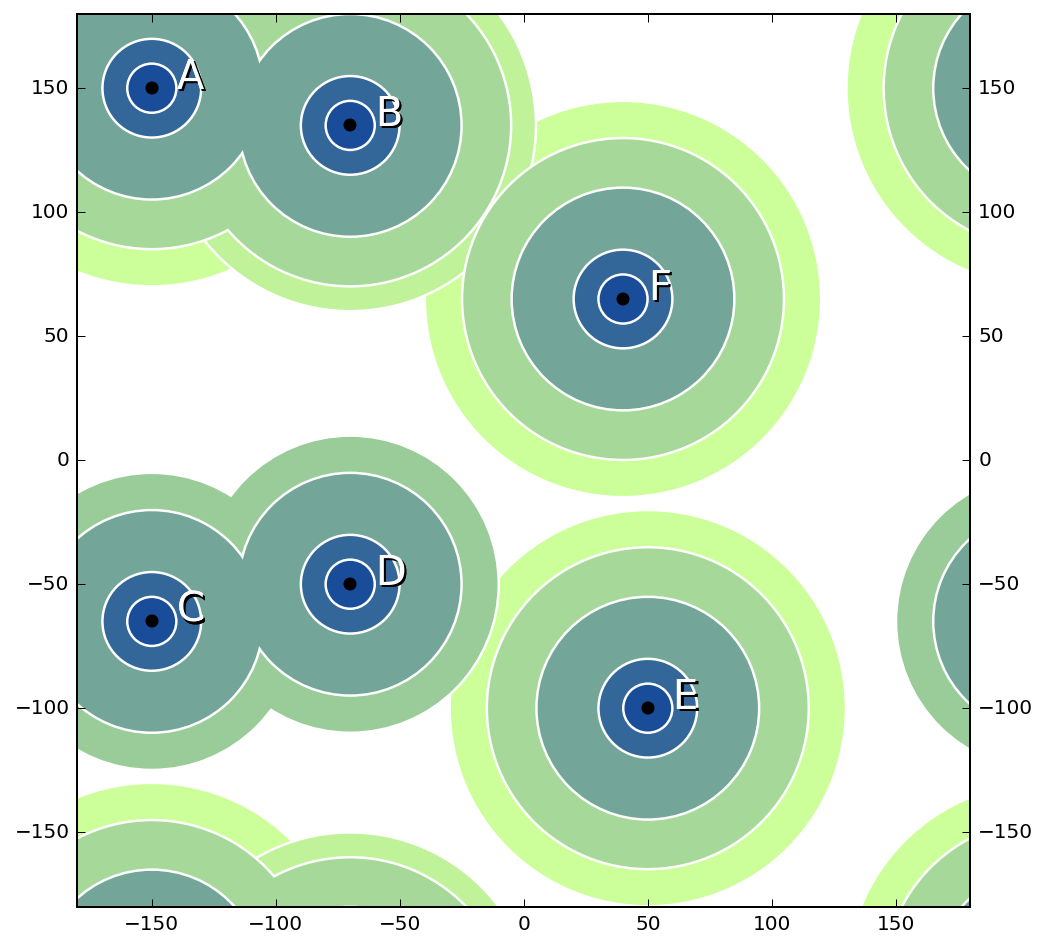

In [53]:
#! skip
mstis_calc.live_visualization = paths.LiveVisualization(mstis, phiD, psiD, [-180.0, 180.0], [-180.0, 180.0])
#mstis_calc.live_visualization.background = None
mstis_calc.live_visualization.background = plot_main()
mstis_calc.live_visualization.draw_background()
mstis_calc.visualize_frequency = 1 # increasing this number speeds things up, but isn't as pretty

In [30]:
mstis_calc.live_visualization = None

Now everything is ready: let's run the simulation!

In [35]:
total_samples = 15000
while len(storage.steps) < total_samples:
    try:
        mstis_calc.run_until(total_samples)
    except ValueError:
        pass

Working on Monte Carlo cycle number 15000.

DONE! Completed 15000 Monte Carlo cycles.



In [32]:
# commented out during development, so we can "run all" and then do more
#storage.close()

In [36]:
#! skip
storage.close()